# Import Libraries

In [17]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
import custom_functions as cf
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import metrics
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define functions 

In [2]:
#-------------------------------------------Data Preparation -------------------------------------------------------------------------#
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList
#-------------------------------------------Visualization-----------------------------------------------------------------------------#

def plot_confu_matrix(cm, datatype=None, dataset=None, path = 'confusion_matrix.png'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    fig = plt.figure(figsize=(8, 6))       # size in inches
    # use plot(), etc. to create your plot.
    df_cm = pd.DataFrame(cm, ('0','1'), ('0','1'))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt="d") # font size and decimal appearance
    plt.xlabel('predicted')
    plt.ylabel('true label')
    if dataset is not None:
        plt.title('conf_matrix based on {} data of {} dataset'.format(datatype,dataset))
    #plt.show()
    plt.savefig(path)
    #return fig
#------------------------------------ Network Models ---------------------------------------------------------------------------------#   
def denseModel():
    input_shape =  (cols-1)
    dropout = 0.2
    
    inputs = tf.keras.Input(shape = input_shape) 
    x = layers.Flatten()(inputs)
    x = layers.Dense(128)(x)
    x = layers.Activation('relu')(x)
    if dropout is not None:
        x = layers.Dropout(rate = dropout)(x)

    x = layers.Dense(32)(x)
    x = layers.Activation('relu')(x)   
    if dropout is not None:
        x = layers.Dropout(rate = dropout)(x)

    x = layers.Dense(2)(x)

    outputs = layers.Activation('softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)    
    model.summary()
    return model

# Main Code

In [3]:
#['A1','B1','C1','C3','D1','E1','F','G','H','I','D2','E2','A2','B2','C2','Target']

# ----- IMPORT DATA --------
data_set = pd.read_csv('train.csv', header=0)


Ziel:
Binäre Klassifikation von Daten, Zielvariable: Spalte "Target"

A1, B1, C1, C3, D1, E1:
Anzahl der Treffer einer Datenbanksuche

F, I:
Absolute Werte

G:
Differenz vom Median von F (gruppiert nach einem fehlenden Wert)

H:
Outlier von F (gruppiert nach einem fehlenden Wert)

A2, B2, C2, D2, E2:
Ist der Quotient von A1, B1, C1, D1, E2 mit I

--> Nutze: A2, B2, C2, D2, E2 und G/F und H? C3?


## Data Preparation and visualization

In [25]:
# ---------- DELETE REDUNDANT FEATURES ---------------------------
data = data_set[['A2', 'B2', 'C2','C3', 'D2','E2', 'F', 'H', 'Target']] 
data.describe()

,A2,B2,C2,C3,D2,E2,F,H,Target
count,41131.000000,41131.000000,41131.000000,41131.000000,41131.000000,41131.000000,41131.000000,41131.000000,41131.000000
mean,7.049193,1.708223,15.316366,0.159393,0.387565,0.106687,41.876803,0.240962,0.003185
std,5.907019,33.857118,148.465403,1.798269,7.683818,2.532320,9.519752,0.427672,0.056346
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.470000,0.000000,0.000000,0.000000,0.000000,0.000000,36.170000,0.000000,0.000000
50%,6.110000,0.000000,0.000000,0.000000,0.000000,0.000000,40.940000,0.000000,0.000000
75%,9.725000,0.000000,0.000000,0.000000,0.000000,0.000000,47.340000,0.000000,0.000000
max,54.200000,2491.460000,4206.460000,203.000000,287.360000,294.460000,99.880000,1.000000,1.000000


In [26]:
# ----------------- REMOVE OUTLIER ---------------------------
''' Remove only Outlier for Features A2 and F because otherwise all or near to all samples with Label(Target) == 1 get removed! '''
cleaned = data
for colName in ['A2','F']:
    # Index List of Non-Outliers
    nonOutlierList = Remove_Outlier_Indices(cleaned[colName])
    # Non-Outlier Subset of the Given Dataset
    cleaned = cleaned[nonOutlierList]

#--------- VISUALIZE CLEANED DATA -------------------    
c= 0
for i in cleaned.Target.iteritems():

    if i[1] == 1:
        c+=1

print(c, ' out of 131 Samples with label "1" have been kept')
# cleaned.describe()

118  out of 131 Samples with label "1" have been kept


In [27]:
# ------------- MIN MAX NORMALIZATION --------------------------
# copy the data
scaled = cleaned.copy()

# apply normalization techniques
for column in scaled.columns:
    scaled[column] = (scaled[column] - scaled[column].abs().min()) / (scaled[column].abs().max() - scaled[column].abs().min())

# view normalized data
#scaled.describe()


### Upsampling for neural network 

In [28]:
'''As the data set consists of less than 1 percent samples with label == 1, we simply extend the training set with multiple copies of those samples such that its percentage is ~ 50 %  '''

df = scaled
#shuffle data rows
df = df.sample(frac=1)

#train test split
n = int(0.8 * len(df))
cols = len(df.columns)
print('number of features: ', cols-1)
train = df.iloc[0:n, :]
test = df.iloc[n: , :]

#make copy of x_train for upsampling, this way we can use the original set for validation/analysis purposes later on
df_train = train.copy()

# get row indices of samples with label '1'
c = 0
indices = []
for index, series in df_train.iterrows():        #Iterate over DataFrame rows as (index, Series) pairs.
    if series.Target == 1:
        c += 1
        indices.append(index)
        
samples =[]
for i in indices:
    samples.append(df_train.loc[i])
samples = pd.DataFrame(samples)


Nupsample = 8
for n in range(Nupsample):
    samples = samples.append(samples)
#append samples to original set
df_train = df_train.append(samples)

print('Percentage of samples class 1: ',sum(df_train.Target)/len(df_train.Target))

number of features:  8
Percentage of samples class 1:  0.44894467655957354


In [29]:
#df_train

In [10]:
# ------------ SOME LAST PREPARATION BEFORE TRAINIGN ---------------------------

#split features and labels
x_train = df_train.iloc[ : , : cols-1]
y_train = df_train.iloc[ : , cols-1]
x_test = test.iloc[ : , : cols-1]
y_test = test.iloc[ : , cols-1]

# ------------ ONE HOT ENCODE LABELS ------------------------------------------
Y_train = tf.keras.utils.to_categorical(y_train, 2)
Y_test = tf.keras.utils.to_categorical(y_test, 2)
print('number of samples class 1: ',sum(y_train)+sum(y_test))

number of samples class 1:  25974.0


## Build Network Model

In [34]:
model = denseModel()
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=lr) 
                                            #beta_1 = config.beta_1, 
                                            #beta_2 = config.beta_2,
                                            #epsilon = config.epsilon) 
lossfct = tf.keras.losses.BinaryCrossentropy(from_logits = True)
model.compile(optimizer = optimizer, loss = lossfct)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1152      
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
activation_7 (Activation)    (None, 32)               

## Train Model

Epoch 1/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.6266 - val_loss: 0.5676
Epoch 2/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5557 - val_loss: 0.5279
Epoch 3/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5248 - val_loss: 0.5132
Epoch 4/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5152 - val_loss: 0.5085
Epoch 5/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5123 - val_loss: 0.5078
Epoch 6/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5109 - val_loss: 0.5084
Epoch 7/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5102 - val_loss: 0.5077
Epoch 8/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5096 - val_loss: 0.5075
Epoch 9/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.5092 - val_loss: 0.5077
Epoch 10/15
1768/1768 [==============================] - 2s 1ms/step - loss: 0.509

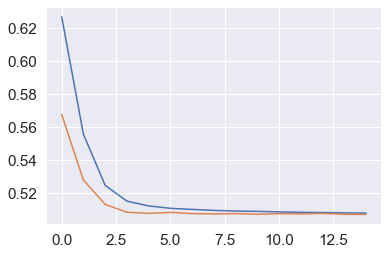

In [35]:
# -------------- TRAIN MODEL ---------------------------------------------------
history = model.fit(x_train , Y_train , epochs = 15 , validation_data = ( x_test , Y_test), batch_size = 32)
model.save("model.h5")
log = pd.DataFrame(history.history)
log.to_csv("train_log.csv",index=False)
print("saved training log")

# --------------- VISUALIZE TRAINING PROCESS ------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Validation and Performance Analysis

In [36]:
# ------ LOAD MODEL ---------
lmodel = tf.keras.models.load_model('model.h5')

# ------- ACCURACIES ------------------------------
y_pred = np.argmax(lmodel.predict(x_test), axis=1)
y_pred_train = np.argmax(lmodel.predict(x_train), axis=1)
print('Accuracy on test data: ',metrics.accuracy_score(y_test,y_pred))
print('Accuracy on train data: ',metrics.accuracy_score(y_train,y_pred_train))

Accuracy on test data:  0.9917915309446254
Accuracy on train data:  0.9913000424388174


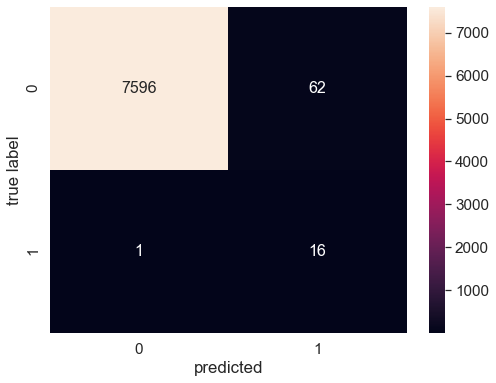

In [37]:
# ---------- CONFUSION MATRIX -----------------
y_pred = np.argmax(lmodel.predict(x_test), axis=1)

cm = metrics.confusion_matrix(y_true = y_test,y_pred = y_pred)
plot_confu_matrix(cm)